In [1]:
#
import pandas
from statsmodels.tsa.seasonal import MSTL
from matplotlib import pyplot

#
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import pandas as pd
import torch

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

#


C:\TET\env\macrox\lib\site-packages\bitsandbytes\cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [2]:
from pytorch_lightning import loggers as pl_loggers
tensorboard = pl_loggers.TensorBoardLogger('./')

In [3]:
# driver = 'JTU5300QUL'
# driver = 'QUSR628BIS'
# driver = 'RAILFRTCARLOADSD11'
# driver = 'FRGSHPUSM649NCIS'
# driver = 'TSIFRGHT'
# driver = 'AIRRTMFMD11'
driver = 'CUUR0000SEHA'
series = pandas.read_csv('./data/{0}.csv'.format(driver))
# series = data[[driver]].copy()
# series = series.reset_index().rename(columns={'jx': 'ds', driver: 'y'})
series = series.rename(columns={'DATE': 'ds', driver: 'y'})
series['ds'] = pandas.to_datetime(series['ds'])
series['y'] = series['y'].apply(func=lambda x: pandas.NA if x == '.' else x)
series['y'] = series['y'].ffill()
series['y'] = pandas.to_numeric(series['y'])
series = series[series['ds'] > '1970-01-01']
# series['y'] = series['y'].pct_change()
# series = series[series['ds'] > '2000-01-01']
series

,ds,y
662,1970-02-01,45.800
663,1970-03-01,46.000
664,1970-04-01,46.100
665,1970-05-01,46.200
666,1970-06-01,46.400
...,...,...
1301,2023-05-01,396.726
1302,2023-06-01,398.593
1303,2023-07-01,400.210
1304,2023-08-01,402.247


In [4]:
# series.set_index('ds').iloc[80:120, :].plot(style='.')  # '.-'

<Axes: xlabel='ds'>

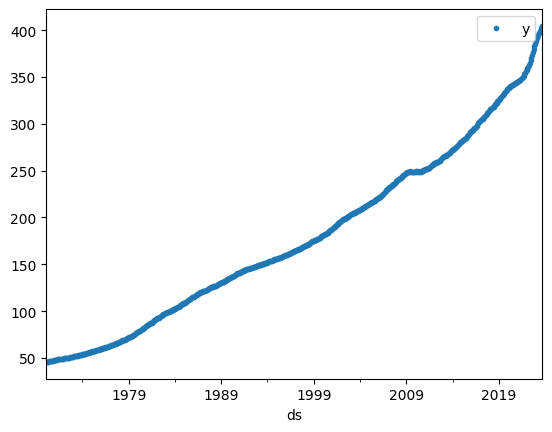

In [5]:
series.set_index('ds').plot(style='.')  # '.-'

In [6]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 5

# training_cutoff = (series.shape[0] - 1) - max_prediction_length
training_cutoff = int(series.shape[0] / 2)
series['time_idx'] = list(range(series.shape[0]))
series['group'] = 0

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    series.iloc[:training_cutoff, :],
    time_idx="time_idx",
    target="y",
    # categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["group"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["y"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, series, min_prediction_idx=training_cutoff)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [7]:
# pl.seed_everything(42)
trainer = pl.Trainer(accelerator="auto", gradient_clip_val=0.01)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\TET\env\macrox\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\TET\env\macrox\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
C:\TET\env\macrox\lib\site-packages\pytorch_forecasting\models\nbeats\sub_modules.py:154: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\

C:\TET\env\macrox\lib\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
C:\TET\env\macrox\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\TET\env\macrox\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
C:\TET\env\macrox\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.007079457843841375
Restoring states from the checkpoint path at C:\TET\macro\.lr_find_510c871e-1633-4f5b-a55d-a9976d099468.ckpt
Restored all states from the checkpoint at C:\TET\macro\.lr_find_510c871e-1633-4f5b-a55d-a9976d099468.ckpt


suggested learning rate: 0.007079457843841375


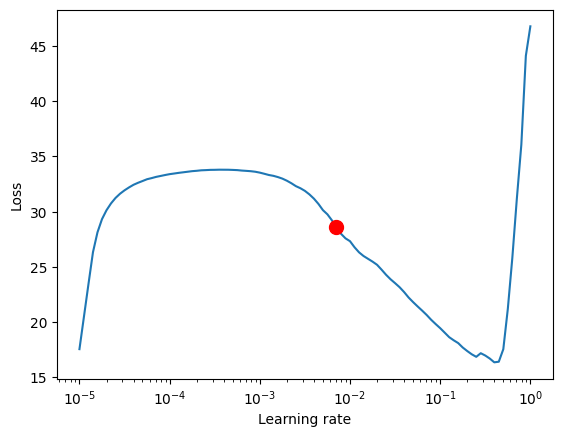

C:\Users\Edward\AppData\Local\Temp\ipykernel_10456\330161667.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [8]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [9]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=500,
    accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=150,
    # logger=tensorboard
)


net = NBeats.from_dataset(
    training,
    learning_rate=1e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    stack_types = ['trend', 'seasonality'],
    widths=[32, 512],
    backcast_loss_ratio=1.0,
    # logger=tensorboard
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    # logger=tensorboard
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\TET\env\macrox\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\TET\env\macrox\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable param

Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

In [10]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [11]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

C:\TET\env\macrox\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


tensor(1.1173)

In [43]:
raw_predictions = best_model.predict(val_dataloader, mode="raw", return_x=True, return_y=False)

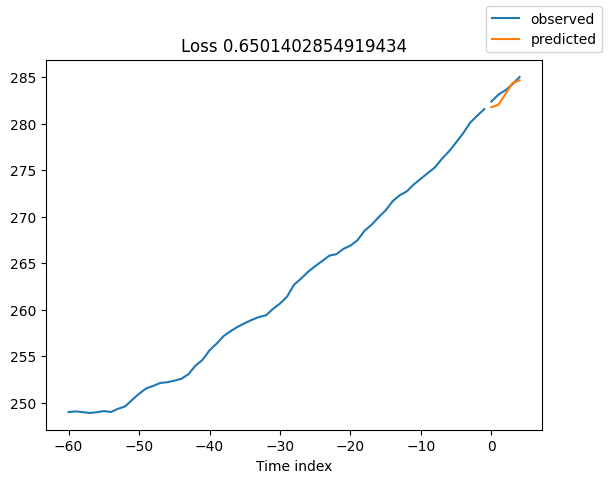

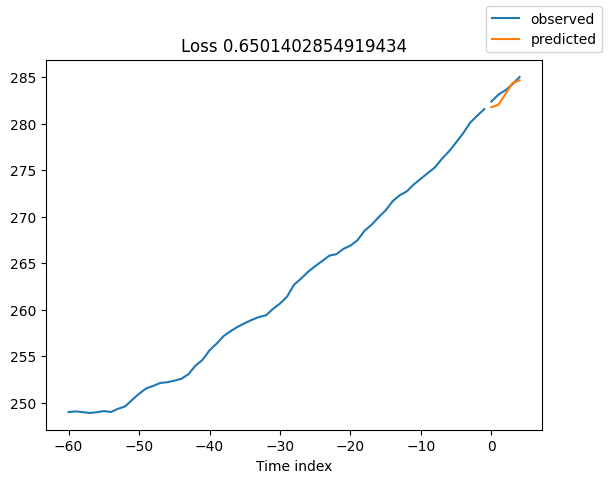

In [13]:
best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=-100, add_loss_to_title=True)

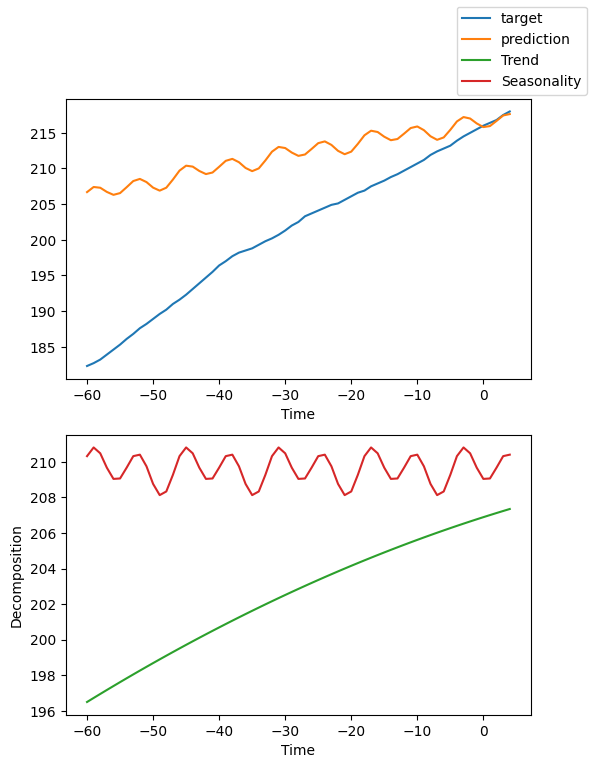

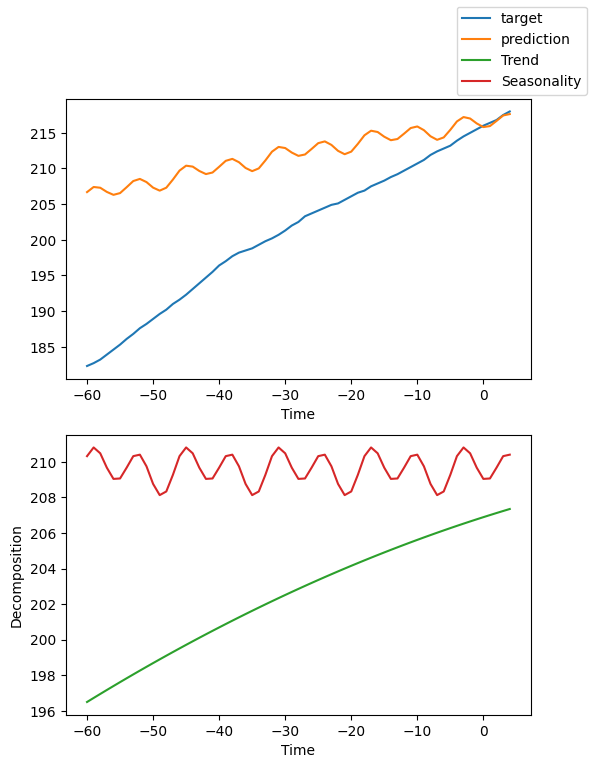

In [14]:
best_model.plot_interpretation(raw_predictions.x, raw_predictions.output, idx=100)

In [39]:
net

NBeats(
  	"backcast_loss_ratio":           1.0
  	"context_length":                60
  	"dropout":                       0.1
  	"expansion_coefficient_lengths": [3, 7]
  	"learning_rate":                 0.001
  	"log_gradient_flow":             False
  	"log_interval":                  10
  	"log_val_interval":              1
  	"logging_metrics":               ModuleList(
  	  (0): SMAPE()
  	  (1): MAE()
  	  (2): RMSE()
  	  (3): MAPE()
  	  (4): MASE()
  	)
  	"loss":                          MASE()
  	"monotone_constaints":           {}
  	"num_block_layers":              [3, 3]
  	"num_blocks":                    [3, 3]
  	"optimizer":                     Ranger
  	"optimizer_params":              None
  	"output_transformer":            EncoderNormalizer(
  		method='standard',
  		center=True,
  		max_length=None,
  		transformation='relu',
  		method_kwargs={}
  	)
  	"prediction_length":             5
  	"reduce_on_plateau_min_lr":      1e-05
  	"reduce_on_plateau_patience

In [15]:
raw_predictions

Prediction(output=Output(prediction=tensor([[163.8442, 163.9321, 164.4521, 165.0176, 165.1958],
        [164.1666, 164.2569, 164.7950, 165.3854, 165.5821],
        [164.5014, 164.5971, 165.1479, 165.7479, 165.9426],
        ...,
        [390.9784, 392.6306, 395.8621, 398.0815, 397.3728],
        [394.1223, 395.8336, 399.2107, 401.5454, 400.8240],
        [397.1190, 398.8510, 402.3515, 404.8136, 404.1188]]), backcast=tensor([[158.8777, 159.3240, 159.2007,  ..., 164.9252, 164.7444, 164.2288],
        [159.2000, 159.6465, 159.5124,  ..., 165.2870, 165.0959, 164.5634],
        [159.5039, 159.9551, 159.8131,  ..., 165.6499, 165.4501, 164.9046],
        ...,
        [376.6084, 377.6385, 375.7230,  ..., 397.1777, 395.0813, 392.1530],
        [379.3580, 380.4427, 378.4405,  ..., 400.6316, 398.4427, 395.3702],
        [381.8782, 383.0515, 380.9971,  ..., 403.9207, 401.6734, 398.4648]]), trend=tensor([[151.8671, 151.9963, 152.1245,  ..., 157.9413, 158.0070, 158.0717],
        [152.1844, 152.3141

In [41]:
raw_predictions.keys()

('output', 'x', 'index', 'decoder_lengths', 'y')

In [16]:
list(raw_predictions.x.keys())

['encoder_cat',
 'encoder_cont',
 'encoder_target',
 'encoder_lengths',
 'decoder_cat',
 'decoder_cont',
 'decoder_target',
 'decoder_lengths',
 'decoder_time_idx',
 'groups',
 'target_scale']

In [21]:
raw_predictions.x['target_scale']

tensor([[153.8833,   5.4359],
        [154.1967,   5.4686],
        [154.5134,   5.5006],
        [154.8333,   5.5317],
        [155.1450,   5.5751],
        [155.4667,   5.6069],
        [155.7934,   5.6347],
        [156.1233,   5.6669],
        [156.4533,   5.7030],
        [156.7917,   5.7347],
        [157.1350,   5.7673],
        [157.4717,   5.8144],
        [157.8067,   5.8733],
        [158.1483,   5.9247],
        [158.4917,   5.9763],
        [158.8383,   6.0254],
        [159.1917,   6.0661],
        [159.5417,   6.1148],
        [159.8950,   6.1606],
        [160.2517,   6.2149],
        [160.6150,   6.2662],
        [160.9817,   6.3255],
        [161.3550,   6.3872],
        [161.7300,   6.4529],
        [162.1116,   6.5205],
        [162.4950,   6.5857],
        [162.8800,   6.6486],
        [163.2600,   6.7140],
        [163.6400,   6.7798],
        [164.0250,   6.8383],
        [164.4150,   6.8834],
        [164.8100,   6.9205],
        [165.2033,   6.9605],
        [1

In [18]:
raw_predictions.x['decoder_target']

tensor([[164.0000, 164.4000, 164.8000, 165.1000, 165.5000],
        [164.4000, 164.8000, 165.1000, 165.5000, 165.9000],
        [164.8000, 165.1000, 165.5000, 165.9000, 166.4000],
        ...,
        [392.9100, 394.8980, 396.7260, 398.5930, 400.2100],
        [394.8980, 396.7260, 398.5930, 400.2100, 402.2470],
        [396.7260, 398.5930, 400.2100, 402.2470, 404.4870]])

In [77]:
list(raw_predictions.output.keys())

['prediction', 'backcast', 'trend', 'seasonality', 'generic']

In [81]:
raw_predictions.x['encoder_target']

tensor([[145.2000, 145.4000, 145.6000,  ..., 162.9000, 163.3000, 163.7000],
        [145.4000, 145.6000, 146.4000,  ..., 163.3000, 163.7000, 164.0000],
        [145.6000, 146.4000, 146.2000,  ..., 163.7000, 164.0000, 164.4000],
        ...,
        [315.8830, 316.7630, 317.4900,  ..., 385.6490, 388.3720, 391.1410],
        [316.7630, 317.4900, 318.3180,  ..., 388.3720, 391.1410, 392.9100],
        [317.4900, 318.3180, 319.3510,  ..., 391.1410, 392.9100, 394.8980]])

In [49]:
raw_predictions.output['prediction']

tensor([[163.8442, 163.9321, 164.4521, 165.0176, 165.1958],
        [164.1666, 164.2569, 164.7950, 165.3854, 165.5821],
        [164.5014, 164.5971, 165.1479, 165.7479, 165.9426],
        ...,
        [390.9784, 392.6306, 395.8621, 398.0815, 397.3728],
        [394.1223, 395.8336, 399.2107, 401.5454, 400.8240],
        [397.1190, 398.8510, 402.3515, 404.8136, 404.1188]])

In [55]:
raw_predictions.output['backcast']

tensor([[158.8777, 159.3240, 159.2007,  ..., 164.9252, 164.7444, 164.2288],
        [159.2000, 159.6465, 159.5124,  ..., 165.2870, 165.0959, 164.5634],
        [159.5039, 159.9551, 159.8131,  ..., 165.6499, 165.4501, 164.9046],
        ...,
        [376.6084, 377.6385, 375.7230,  ..., 397.1777, 395.0813, 392.1530],
        [379.3580, 380.4427, 378.4405,  ..., 400.6316, 398.4427, 395.3702],
        [381.8782, 383.0515, 380.9971,  ..., 403.9207, 401.6734, 398.4648]])

In [56]:
raw_predictions.output['trend']

tensor([[151.8671, 151.9963, 152.1245,  ..., 157.9413, 158.0070, 158.0717],
        [152.1844, 152.3141, 152.4428,  ..., 158.3032, 158.3698, 158.4354],
        [152.4568, 152.5880, 152.7180,  ..., 158.6338, 158.7009, 158.7670],
        ...,
        [338.5490, 338.9899, 339.4276,  ..., 359.7813, 360.0221, 360.2596],
        [339.6742, 340.1297, 340.5819,  ..., 361.6127, 361.8615, 362.1070],
        [340.7938, 341.2646, 341.7320,  ..., 363.4719, 363.7292, 363.9831]])

In [57]:
raw_predictions.output['seasonality']

tensor([[160.8940, 161.2110, 160.9594,  ..., 160.3941, 160.8940, 161.0074],
        [161.2122, 161.5290, 161.2662,  ..., 160.6885, 161.2122, 161.3434],
        [161.5604, 161.8805, 161.6084,  ..., 161.0275, 161.5604, 161.6890],
        ...,
        [382.7929, 383.3822, 381.0290,  ..., 380.8143, 382.7929, 381.8467],
        [385.7013, 386.3304, 383.8760,  ..., 383.6154, 385.7013, 384.7344],
        [388.4040, 389.1065, 386.5847,  ..., 386.1992, 388.4040, 387.4554]])

In [58]:
raw_predictions.output['generic']

tensor([[153.8833, 153.8833, 153.8833,  ..., 153.8833, 153.8833, 153.8833],
        [154.1967, 154.1967, 154.1967,  ..., 154.1967, 154.1967, 154.1967],
        [154.5134, 154.5134, 154.5134,  ..., 154.5134, 154.5134, 154.5134],
        ...,
        [344.7336, 344.7336, 344.7336,  ..., 344.7336, 344.7336, 344.7336],
        [346.0174, 346.0174, 346.0174,  ..., 346.0174, 346.0174, 346.0174],
        [347.3196, 347.3196, 347.3196,  ..., 347.3196, 347.3196, 347.3196]])

In [53]:
zz = ((raw_predictions.output['trend'] + raw_predictions.output['seasonality'] + raw_predictions.output['generic']) / 3)[:, 60:]
zz

tensor([[157.2036, 157.2329, 157.4063, 157.5948, 157.6541],
        [157.5200, 157.5501, 157.7294, 157.9262, 157.9918],
        [157.8427, 157.8746, 158.0582, 158.2582, 158.3231],
        ...,
        [360.1485, 360.6992, 361.7765, 362.5162, 362.2800],
        [362.0523, 362.6228, 363.7485, 364.5267, 364.2863],
        [363.9194, 364.4967, 365.6636, 366.4843, 366.2527]])

In [64]:
gg = ((raw_predictions.output['prediction'] - raw_predictions.output['seasonality'][:, 60:]))
gg

tensor([[ 3.9235,  3.9913,  4.0580,  4.1237,  4.1883],
        [ 3.9701,  4.0388,  4.1065,  4.1731,  4.2388],
        [ 3.9831,  4.0523,  4.1204,  4.1875,  4.2536],
        ...,
        [14.5565, 14.8038, 15.0477, 15.2885, 15.5261],
        [15.0876, 15.3431, 15.5953, 15.8441, 16.0896],
        [15.6273, 15.8915, 16.1523, 16.4096, 16.6634]])

In [68]:
xx = ((raw_predictions.output['trend'] - raw_predictions.output['seasonality']))[:, 60:]
xx

tensor([[ -2.1138,  -2.0662,  -2.4528,  -2.8869,  -2.9358],
        [ -2.0297,  -1.9826,  -2.3853,  -2.8424,  -2.9079],
        [ -2.0218,  -1.9791,  -2.3937,  -2.8595,  -2.9220],
        ...,
        [-17.1318, -18.2895, -21.0330, -22.7708, -21.5871],
        [-17.9296, -19.1299, -22.0027, -23.8398, -22.6274],
        [-18.5446, -19.7482, -22.7273, -24.6748, -23.4723]])

In [74]:
dd = ((raw_predictions.x['decoder_target'] - raw_predictions.output['seasonality'][:, 60:]))
dd

tensor([[ 4.0793,  4.4592,  4.4059,  4.2061,  4.4926],
        [ 4.2035,  4.5819,  4.4115,  4.2878,  4.5566],
        [ 4.2817,  4.5552,  4.4725,  4.3396,  4.7110],
        ...,
        [16.4881, 17.0712, 15.9117, 15.8000, 18.3633],
        [15.8634, 16.2356, 14.9776, 14.5087, 17.5126],
        [15.2344, 15.6336, 14.0108, 13.8430, 17.0316]])

In [79]:
ll = ((raw_predictions.x['decoder_target'] - raw_predictions.output['prediction']))
ll

tensor([[ 0.1558,  0.4679,  0.3479,  0.0824,  0.3042],
        [ 0.2334,  0.5431,  0.3050,  0.1146,  0.3179],
        [ 0.2986,  0.5029,  0.3521,  0.1521,  0.4574],
        ...,
        [ 1.9316,  2.2674,  0.8640,  0.5115,  2.8372],
        [ 0.7757,  0.8925, -0.6177, -1.3354,  1.4230],
        [-0.3930, -0.2580, -2.1415, -2.5666,  0.3682]])

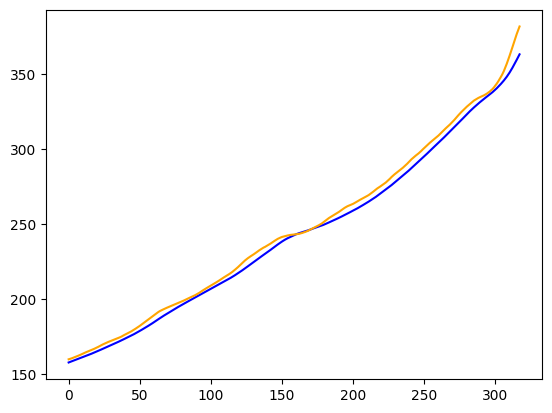

In [71]:
pyplot.plot(range(raw_predictions.output['trend'][:, 0].shape[0]),raw_predictions.output['trend'][:, 60], 'blue')
pyplot.plot(range(raw_predictions.output['seasonality'][:, 0].shape[0]), raw_predictions.output['seasonality'][:, 60], 'orange')

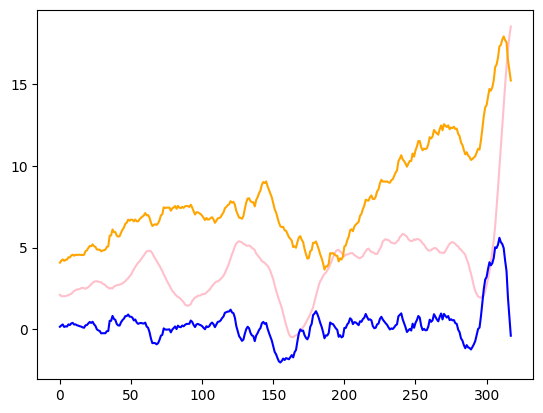

In [80]:
pyplot.plot(range(xx[:, 0].shape[0]), -xx[:, 0], 'pink')
pyplot.plot(range(dd[:, 0].shape[0]), dd[:, 0], 'orange')
pyplot.plot(range(ll[:, 0].shape[0]), ll[:, 0], 'blue')

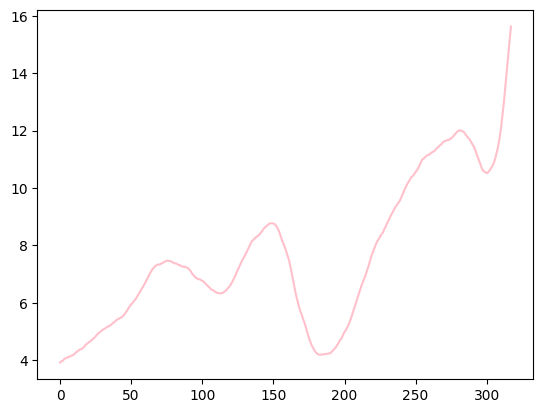

In [65]:
from matplotlib import pyplot
# pyplot.plot(range(raw_predictions.output['prediction'][:, 0].shape[0]), raw_predictions.output['prediction'][:, 0], 'blue')
# pyplot.plot(range(raw_predictions.x['decoder_target'][:, 0].shape[0]), raw_predictions.x['decoder_target'][:, 0], 'orange')
# pyplot.plot(range(zz[:, 0].shape[0]), zz[:, 0], 'pink')
## pyplot.plot(range(raw_predictions.output['trend'][:, 0].shape[0]),raw_predictions.output['trend'][:, 60], 'blue')
## pyplot.plot(range(raw_predictions.output['seasonality'][:, 0].shape[0]), raw_predictions.output['seasonality'][:, 60], 'orange')
## pyplot.plot(range(raw_predictions.output['generic'][:, 0].shape[0]), raw_predictions.output['generic'][:, 60], 'pink')
pyplot.plot(range(gg[:, 0].shape[0]), gg[:, 0], 'pink')
pyplot.plot(range(gg[:, 0].shape[0]), gg[:, 0], 'pink')

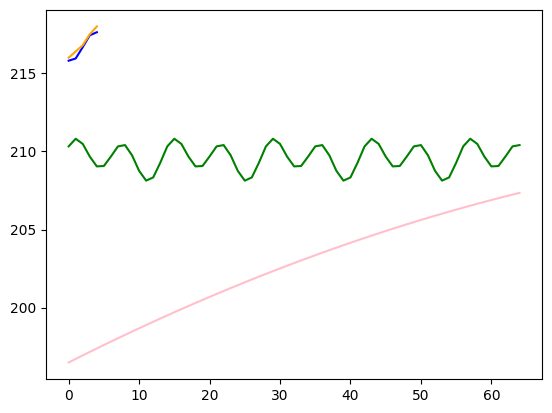

In [22]:
from matplotlib import pyplot
# pyplot.plot(range(raw_predictions.x['decoder_target'][:, 0].shape[0]), raw_predictions.x['decoder_target'][:, 0], 'blue')
pyplot.plot(range(raw_predictions.output['prediction'][100, :].shape[0]), raw_predictions.output['prediction'][100, :], 'blue')
pyplot.plot(range(raw_predictions.x['decoder_target'][100, :].shape[0]), raw_predictions.x['decoder_target'][100, :], 'orange')
pyplot.plot(range(raw_predictions.output['trend'][100, :].shape[0]), raw_predictions.output['trend'][100, :], 'pink')
pyplot.plot(range(raw_predictions.output['seasonality'][100, :].shape[0]), raw_predictions.output['seasonality'][100, :], 'green')

In [23]:
raw_predictions.output['seasonality'][:, 0] + raw_predictions.output['trend'][:, 0]

tensor([312.7610, 313.3967, 314.0172, 314.7319, 315.3571, 316.0848, 316.7762,
        317.5127, 318.2298, 318.9925, 319.8154, 320.6085, 321.3655, 322.0821,
        322.8190, 323.5709, 324.3419, 325.0690, 325.8168, 326.5878, 327.3939,
        328.2267, 329.1160, 329.9854, 330.8948, 331.7211, 332.5475, 333.3441,
        334.0964, 334.8568, 335.5590, 336.2953, 337.0067, 337.6674, 338.3698,
        339.0707, 339.9149, 340.7592, 341.7480, 342.6965, 343.6287, 344.5319,
        345.4082, 346.3056, 347.2695, 348.2730, 349.3064, 350.4042, 351.4927,
        352.6396, 353.7395, 354.9360, 356.1415, 357.3290, 358.5522, 359.7773,
        360.9716, 362.2028, 363.4467, 364.7007, 365.9600, 367.2292, 368.4381,
        369.6211, 370.7578, 371.7708, 372.6988, 373.6188, 374.5377, 375.4108,
        376.2493, 377.0879, 377.9680, 378.8165, 379.7429, 380.6227, 381.5355,
        382.4144, 383.2914, 384.1625, 385.0768, 385.9569, 386.9291, 387.8558,
        388.8408, 389.7797, 390.7352, 391.7430, 392.7038, 393.77

In [24]:
raw_predictions.output['prediction'][:, 0]

tensor([163.8442, 164.1666, 164.5014, 164.9557, 165.3163, 165.7310, 166.0994,
        166.5372, 166.9408, 167.4069, 167.9066, 168.3979, 168.8519, 169.2765,
        169.7129, 170.1345, 170.5807, 171.0055, 171.4553, 171.9393, 172.4362,
        172.9507, 173.5097, 174.0378, 174.5909, 175.0939, 175.6014, 176.0665,
        176.5034, 176.9456, 177.3399, 177.7422, 178.1386, 178.5124, 178.9053,
        179.2770, 179.7824, 180.2796, 180.8654, 181.4237, 181.9777, 182.4632,
        182.9678, 183.4655, 184.0338, 184.6492, 185.2916, 185.9884, 186.6931,
        187.4242, 188.1277, 188.8854, 189.6586, 190.3984, 191.1839, 191.9664,
        192.7282, 193.5082, 194.3348, 195.1488, 195.9896, 196.8287, 197.6072,
        198.3711, 199.0611, 199.6488, 200.1343, 200.6495, 201.1198, 201.5521,
        201.9591, 202.3923, 202.8399, 203.2439, 203.7104, 204.1199, 204.5140,
        204.9003, 205.2865, 205.6169, 206.0220, 206.4258, 206.8862, 207.2777,
        207.7554, 208.1699, 208.5705, 209.0176, 209.4243, 209.87

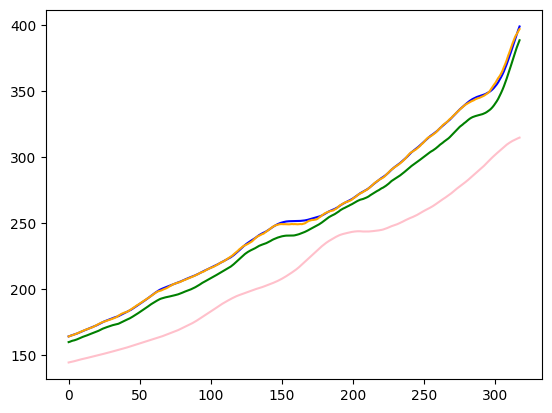

In [107]:
from matplotlib import pyplot
# pyplot.plot(range(raw_predictions.x['decoder_target'][:, 0].shape[0]), raw_predictions.x['decoder_target'][:, 0], 'blue')
pyplot.plot(range(raw_predictions.output['prediction'][:, 0].shape[0]), raw_predictions.output['prediction'][:, 0], 'blue')
pyplot.plot(range(raw_predictions.x['decoder_target'][:, 0].shape[0]), raw_predictions.x['decoder_target'][:, 0], 'orange')
pyplot.plot(range(raw_predictions.output['trend'][:, 0].shape[0]), raw_predictions.output['trend'][:, 0], 'pink')
pyplot.plot(range(raw_predictions.output['seasonality'][:, 0].shape[0]), raw_predictions.output['seasonality'][:, 0], 'green')

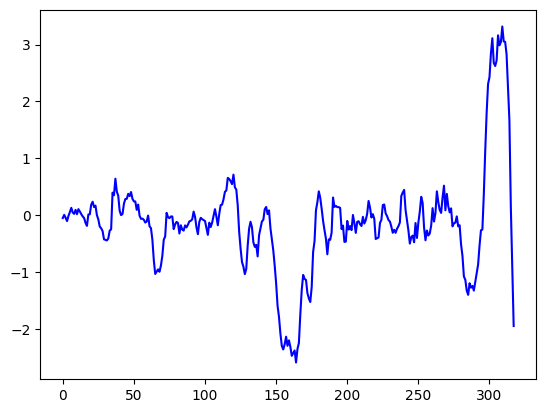

In [108]:
from matplotlib import pyplot
zz = raw_predictions.x['decoder_target'][:, 0] - raw_predictions.output['prediction'][:, 0]
# pyplot.plot(range(raw_predictions.x['decoder_target'][:, 0].shape[0]), raw_predictions.x['decoder_target'][:, 0], 'blue')
pyplot.plot(range(zz.shape[0]), zz, 'blue')

In [ ]:
from matplotlib import pyplot
# pyplot.plot(range(raw_predictions.x['decoder_target'][:, 0].shape[0]), raw_predictions.x['decoder_target'][:, 0], 'blue')
pyplot.plot(range(raw_predictions.output['prediction'][:, 0].shape[0]), raw_predictions.x['decoder_target'][:, 0], 'blue')
pyplot.plot(range(raw_predictions.x['decoder_target'][:, 0].shape[0]), raw_predictions.x['decoder_target'][:, 0], 'orange')

In [57]:
raw_predictions[0]

Output(prediction=tensor([[164.0527, 164.2372, 164.6983, 165.1500, 165.3002],
        [164.3962, 164.5624, 165.0236, 165.4981, 165.6815],
        [164.8470, 165.0133, 165.4955, 165.9961, 166.1913],
        ...,
        [392.7722, 394.8297, 398.3586, 400.7689, 400.2346],
        [395.7813, 397.9120, 401.6141, 404.1754, 403.6642],
        [398.6786, 400.8518, 404.6781, 407.3624, 406.8915]]), backcast=tensor([[150.1886, 150.7416, 150.8863,  ..., 164.4964, 164.4588, 164.2003],
        [150.4366, 151.0084, 151.1657,  ..., 164.8550, 164.8288, 164.5642],
        [150.8352, 151.4224, 151.5713,  ..., 165.3614, 165.3253, 165.0355],
        ...,
        [351.4965, 352.9008, 351.4919,  ..., 398.1756, 396.1758, 393.5344],
        [353.6341, 355.0822, 353.5785,  ..., 401.5211, 399.4121, 396.6163],
        [355.4882, 356.9886, 355.4360,  ..., 404.6512, 402.4777, 399.5741]]), trend=tensor([[144.3243, 144.6628, 144.9979,  ..., 159.1492, 159.2857, 159.4190],
        [144.5578, 144.8985, 145.2358,  ..., 

In [59]:

xx = pandas.DataFrame(data={'yhat': raw_predictions[0][0][:, 0],
                            'y': 

tensor([164.0527, 164.3962, 164.8470, 165.2058, 165.5145, 165.8465, 166.2726,
        166.7547, 167.2781, 167.7080, 168.1843, 168.5955, 169.0370, 169.4830,
        169.9226, 170.3514, 170.8365, 171.2900, 171.6886, 172.1864, 172.6157,
        173.1649, 173.7583, 174.3338, 174.9007, 175.3765, 175.8014, 176.2320,
        176.6825, 177.1271, 177.5358, 177.9465, 178.3116, 178.6727, 179.0506,
        179.4048, 179.9511, 180.4598, 181.0876, 181.6603, 182.2265, 182.7000,
        183.1817, 183.7001, 184.3167, 185.0140, 185.7258, 186.4660, 187.1940,
        187.9142, 188.6581, 189.3603, 190.1078, 190.8146, 191.6119, 192.3666,
        193.1613, 193.9832, 194.8313, 195.6121, 196.4079, 197.1970, 197.9304,
        198.6323, 199.2945, 199.8359, 200.2948, 200.7561, 201.1972, 201.5886,
        202.0177, 202.4330, 202.8760, 203.2596, 203.7366, 204.1541, 204.5235,
        204.9247, 205.3471, 205.7631, 206.2193, 206.7391, 207.2243, 207.6791,
        208.1548, 208.5729, 208.9810, 209.4169, 209.8678, 210.31

In [ ]:
from sklearn.metrics import r2_score
from functional import SomersD as somersd

In [ ]:
r2_score(y_true=predictions['y'].values, y_pred=predictions['yhat'].values)

In [ ]:
somersd(x=predictions['y'].values, y=predictions['yhat'].values)

<Axes: xlabel='ds'>

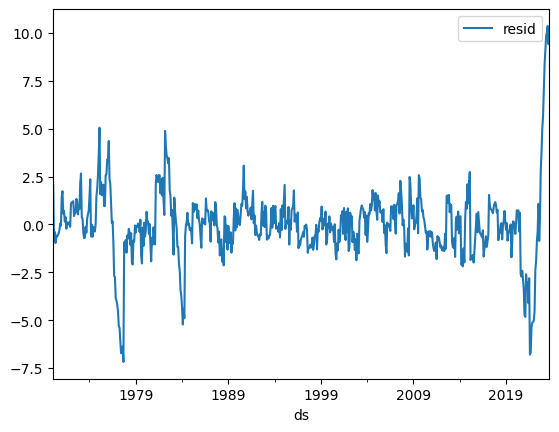

In [793]:
predictions.set_index('ds')[['resid']].plot()

<Axes: >

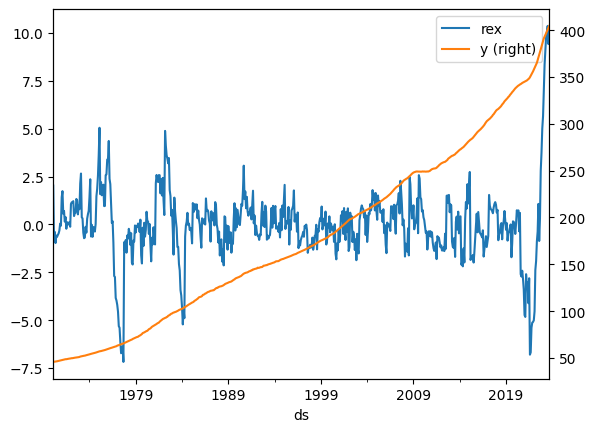

In [794]:
predictions['rex'] = predictions['y'] - predictions[''] - predictions['trend'] - predictions['yearly']
ax = predictions.set_index('ds')[['rex']].plot()
predictions.set_index('ds')[['y']].plot(secondary_y=True, ax=ax)

In [795]:
predictions.columns

Index(['ds', 'y', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower',
       'trend_upper', '', '_lower', '_upper', 'additive_terms',
       'additive_terms_lower', 'additive_terms_upper', 'yearly',
       'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat',
       'resid', 'rex'],
      dtype='object')

In [726]:
# from prophet.plot import plot_plotly, plot_components_plotly

# plot_plotly(m, forecast)

In [460]:
# plot_components_plotly(m, forecast)